### Problem Statement:

To build a content based recommender system that would recommend books to a reader with respect to the reader's personal choice of book, preferred author and average ratings of the book suitable to the reader.

### Importing Required Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
df_book=pd.read_csv('books.csv',usecols=['bookID','title','authors','average_rating'])
df_book.head()

,bookID,title,authors,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78


In [3]:
df_book.shape

(11123, 4)

### Checking the data-types:

In [4]:
df_book.dtypes

bookID              int64
title              object
authors            object
average_rating    float64
dtype: object

### Checking for null values:

In [5]:
df_book.isnull().sum()

bookID            0
title             0
authors           0
average_rating    0
dtype: int64

No null values present in the dataset.

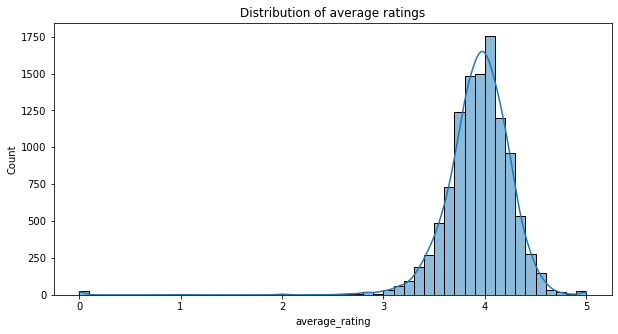

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(df_book['average_rating'],bins=50,kde=True)
plt.title("Distribution of average ratings")
plt.show()

The average of ratings given seems to be around 4 to 4.1 as per the histogram above.

#### Calculating the total count of ratings each book has recieved since it plays an important role in identifying popular books:

In [7]:
df_rating=df_book.groupby('title').agg({'average_rating':'count'}).reset_index().rename(columns={'average_rating':'total_rating'})
df_rating.head()

,title,total_rating
0,said the shotgun to the head.,1
1,$30 Film School: How to Write Direct Produce...,1
2,'Salem's Lot,8
3,1 000 Places to See Before You Die,1
4,10 lb Penalty,1


#### Merging the ratings data to the original books data on title column:

In [8]:
df_book_rating=pd.merge(df_book,df_rating,left_on='title',right_on='title',how='left')
df_book_rating.head()

,bookID,title,authors,average_rating,total_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,2
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,1
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,2
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,2
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,1


#### Considering only those books which has a high count of rating:

In [39]:
df_book_best=df_book_rating[df_book_rating['total_rating']>3]
df_book_best.head()

,bookID,title,authors,average_rating,total_rating
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,4
10,16,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,4
22,31,The Lord of the Rings (The Lord of the Rings ...,J.R.R. Tolkien,4.50,4
24,35,The Lord of the Rings (The Lord of the Rings ...,J.R.R. Tolkien/Alan Lee,4.50,4
39,67,The Known World,Edward P. Jones,3.83,4


In [40]:
df_book_best.shape

(354, 5)

## Building a Recommender System with respect to similar Books:

#### Building a pivot table to see the association between each book:

In [41]:
df_book_table=df_book_best.pivot_table(values='average_rating',index='title',columns='bookID').fillna(0)
df_book_table

bookID,14,16,31,35,67,68,69,151,152,153,...,41735,41740,41885,41998,43098,44979,45035,45037,45041,45046
title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Midsummer Night's Dream,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Tale of Two Cities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anna Karenina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.05,4.05,4.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Atlas Shrugged,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Treasure Island,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tripwire (Jack Reacher #3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twelfth Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Converting the pivot table to vectors to find the Nearest Neighbors of each of them :

In [42]:
df_book_mat=csr_matrix(df_book_table)
nn_model=NearestNeighbors(metric='cosine',algorithm='brute')
df_near=nn_model.fit(df_book_mat)
df_near

NearestNeighbors(algorithm='brute', metric='cosine')

In [43]:
random_index=np.random.choice(df_book_table.shape[0])
random_index

37

In [44]:
distance,index=nn_model.kneighbors(df_book_table.iloc[random_index,:].values.reshape(1,-1),n_neighbors=6)

#### Recommendations based on similar Books:

In [45]:
for i in range(len(distance.flatten())):
    if i ==0:
        print ("Top 5 recommendations for {}:".format(df_book_table.index[random_index]))
    else:
        print("{}.{}".format(i,df_book_table.index[index.flatten()[i]]))

Top 5 recommendations for Selected Poems:
1.The Decline and Fall of the Roman Empire
2.The Da Vinci Code (Robert Langdon  #2)
3.The Complete Stories
4.The Enemy (Jack Reacher  #8)
5.The Histories


## Building a Recommender System with respect to Similar Authors:

In [46]:
df_author_tab=df_book_best.pivot_table(values='average_rating',index='title',columns='authors').fillna(0)
df_author_tab

authors,Alexander Pushkin/Charles Johnston/John Bayley,Alexander Pushkin/Charles Johnston/Michael Basker/John Bayley,Alexander Pushkin/James E. Falen,Alexander Pushkin/Tom Beck,Alexander Pushkin/Walter W. Arndt,Anton Chekhov/Laurence Senelick,Aristophanes/Moses Hadas,Arthur Golden,Ayn Rand,Ayn Rand/Leonard Peikoff,...,William Shakespeare/Robert S. Miola/Janet Adelman/Stephen Orgel/Peter Holland,William Shakespeare/Roma Gill,William Shakespeare/Roma Gill/B. Litt,William Shakespeare/Samuel West/Amanda Root/Arkangel Cast,William Shakespeare/SparkNotes,William Shakespeare/Stanley Wells,William Shakespeare/Stephen Orgel/A.R. Braunmuller,William Shakespeare/Stephen Orgel/A.R. Braunmuller/Russ McDonald,Zadie Smith,Zora Neale Hurston/Henry Louis Gates Jr./Sieglinde Lemke
title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
A Midsummer Night's Dream,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,3.94,3.94,0.0,0.0,0.0,0.0,3.94,0.00,0.0
A Tale of Two Cities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
Anna Karenina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
Atlas Shrugged,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.69,3.69,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Treasure Island,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
Tripwire (Jack Reacher #3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
Twelfth Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0


In [47]:
df_author_mat=csr_matrix(df_author_tab)
nn_model2=NearestNeighbors(metric='cosine',algorithm='brute')
df_near2=nn_model2.fit(df_author_mat)
df_near2

NearestNeighbors(algorithm='brute', metric='cosine')

In [48]:
random_index=np.random.choice(df_author_tab.shape[0])
random_index

56

In [49]:
distance2,index2=nn_model2.kneighbors(df_author_tab.iloc[random_index,:].values.reshape(1,-1),n_neighbors=6)

#### Recommendations based on similar Authors:

In [50]:
for i in range(len(distance2.flatten())):
    if i ==0:
        print ("Top 5 recommendations for {}:".format(df_author_tab.index[random_index]))
    else:
        print("{}.{}".format(i,df_author_tab.index[index2.flatten()[i]]))

Top 5 recommendations for The Known World:
1.The Enemy (Jack Reacher  #8)
2.The Decline and Fall of the Roman Empire
3.The Complete Stories
4.The Great Gatsby
5.The Histories


## Building a Recommender System with respect to Similar Ratings:

In [51]:
i="A Tale of Two Cities"
av=df_book_best[df_book_best['title']==i]['average_rating'].unique()
val=range(6)
for j in av:
    
    book=df_book_best[df_book_best['average_rating']<j]['title'].unique()
    print("Top recommendations for {}:\n".format(i))

    for num in range(5):
        print("{}.{}".format(num+1,book[num]))
        

Top recommendations for A Tale of Two Cities:

1.The Known World
2.Treasure Island
3.Atlas Shrugged
4.The Odyssey
5.Great Expectations


### Final Recommender System that takes value from the user to give recommendation:

In [57]:
book=input("Enter name of the Book available in the E-Library:\n").split('\t')
print("\nWhat type of Recommendation would you prefer?")
print("Select one option :\n")
print("1. Similar Book\n2. Similar Author\n3. Similar Rating\n")
option=int(input("Option:"))
if option==1:
    distance,index=nn_model.kneighbors(df_book_table.loc[book[0],:].values.reshape(1,-1),n_neighbors=6)
    for i in range(len(distance.flatten())):
        if i ==0:
            print ("\nTop 5 recommendations for {}:".format(book[0]))
        else:
            print("{}.{}".format(i,df_book_table.index[index.flatten()[i]]))
elif option==2:
    distance2,index2=nn_model2.kneighbors(df_author_tab.loc[book[0],:].values.reshape(1,-1),n_neighbors=6)
    for j in range(len(distance2.flatten())):
        if j ==0:
            print ("Top 5 recommendations for {}:".format(book[0]))
        else:
            print("{}.{}".format(j,df_author_tab.index[index2.flatten()[j]]))
elif option==3:
    av=df_book_best[df_book_best['title']==book[0]]['average_rating'].unique()
    for k in av:

        book_name=df_book_best[df_book_best['average_rating']<k]['title'].unique()
        print("\nTop recommendations for {}:\n".format(book[0]))
        
        for num in range(5):
            print("{}.{}".format(num+1,book_name[num]))
        break
else:
    print("Invalid option!")

Enter name of the Book available in the E-Library:
The Da Vinci Code (Robert Langdon  #2)

What type of Recommendation would you prefer?
Select one option :

1. Similar Book
2. Similar Author
3. Similar Rating

Option:1

Top 5 recommendations for The Da Vinci Code (Robert Langdon  #2):
1.The Enemy (Jack Reacher  #8)
2.The Decline and Fall of the Roman Empire
3.The Complete Stories
4.The Histories
5.The Communist Manifesto
